IPython magic command to render matplotlib plots.

In [1]:
%matplotlib inline

# MERFISH whole mouse brain spatial transcriptomics (Xiaowei Zhuang)

A collection of in situ, spatially resolved transcriptomic profiles of individual cells in the whole mouse brain by multiplexed error-robust fluorescence in situ hybridization (MERFISH) consisting of ~9 million cells using a 1122 gene panel. We performed MERFISH imaging on 245 coronal and sagittal sections from four animal, obtained 9.3 million segmented cells that passed quality control, and integrated the MERFISH data from the four animals with the scRNA-seq data from the Allen Institute to classify cells. We applied a series of filters to select a subset of cells to be visualized on the ABC atlas. We first removed six fractured tissue slices and 9.1 million cells remained after this step. Then we aligned the spatial coordinates of the cells to the Allen-CCF-2020. For coronal slices that can be registered to the CCF, we used the CCF coordinates to define the coordinates of the center point of the midline and removed cells that substantially passed the midline in the other hemisphere (which has not been registered to the CCF). For the sagittal slices that can be registered to the CCF, we used the CCF coordinates to define the coordinates of the center point of the tissue and removed cells that substantially passed the posterior edge (which has not been registered to the CCF). For the 31 anterior and posterior coronal slices and 3 lateral sagittal slices that cannot be registered to the CCF, we manually aligned and oriented the slices. The x, y coordinates are experimentally measured coordinates after rotating and aligning the tissue slices to the CCF, and the z coordinates are estimated position of each tissue slice in the 3D Allen-CCF 2020 space along the slicing axis based on either the registration results (for slices that can be registered to CCF) or positions of the slices measured during tissue sectioning (for the slices that cannot be registered). The z position is set to zero when the estimated position becomes zero or negative. 8.4 million cells remained after this step. The cell-by-gene matrix of the 8.4 millions cells can be downloaded from the AWS bucket of this animal. We then filtered the cells by cell-classification (label transfer) confidence scores calculated during MERFISH-scRNAseq data integration. 7.0 million cells passed the confidence score threshold for cell subclass label transfer and 5.8 million cells further passed the confidence score threshold for cell cluster label transfer. These 5.8 million cells are included in the cell metadata file that can be downloaded from the the AWS bucket and are displayed on the ABC Atlas. The CCF coordinates of the 5.4 million cells that were registered to the 3D Allen-CCF can be downloaded from the CCF coordinate files in the AWB bucket. The collection spans four mouse specimens (2 coronal sets and 2 sagittal sets). Cells are mapped to the whole mouse brain taxonomy (WMB-taxonomy) and Allen Common Coordinate Framework (Allen-CCF-2020). Refer to [Zhang et al, 2023](https://doi.org/10.1101/2023.03.06.531348) for more details.

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [3]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20240831/manifest.json'

In [4]:
datasets = ['Zhuang-ABCA-1', 'Zhuang-ABCA-2', 'Zhuang-ABCA-3', 'Zhuang-ABCA-4']
example_section = {'Zhuang-ABCA-1': 'Zhuang-ABCA-1.079',
                   'Zhuang-ABCA-2': 'Zhuang-ABCA-2.037',
                   'Zhuang-ABCA-3': 'Zhuang-ABCA-3.010',
                   'Zhuang-ABCA-4': 'Zhuang-ABCA-4.002'}

## Data overview

### Cell metadata

Essential cell metadata is stored as a dataframe. Each row represents one cell indexed by a *cell label*.

Each cell is associated with a *brain section label*, *donor label*, *donor genotype*, *donor sex* and *matrix_prefix* identifying which data package this cell is part of. Each cell also has a set of x, y, z coordinates generated by rotating each section so that it is upright with midline approximatedly in the middle of the frame.

Each cell is mapped to the whole mouse brain taxonomy resulting in the assignment of a *cluster alias* and *confidence scores*.

In [5]:
cell = {}

for d in datasets :

    cell[d] = abc_cache.get_metadata_dataframe(
        directory=d,
        file_name='cell_metadata',
        dtype={"cell_label": str}
    )
    cell[d].set_index('cell_label', inplace=True)
    
    sdf = cell[d].groupby('brain_section_label')
    
    print(d,":","Number of cells = ", len(cell[d]), ", ", "Number of sections =", len(sdf))

cell_metadata.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 556M/556M [00:24<00:00, 23.1MMB/s]


Zhuang-ABCA-1 : Number of cells =  2846908 ,  Number of sections = 147


cell_metadata.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 240M/240M [00:10<00:00, 22.3MMB/s]


Zhuang-ABCA-2 : Number of cells =  1227408 ,  Number of sections = 66


cell_metadata.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 310M/310M [00:13<00:00, 23.4MMB/s]


Zhuang-ABCA-3 : Number of cells =  1585843 ,  Number of sections = 23


cell_metadata.csv: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31.9M/31.9M [00:01<00:00, 24.9MMB/s]


Zhuang-ABCA-4 : Number of cells =  162578 ,  Number of sections = 3


In [6]:
cell[datasets[0]]

brain_section_label  \
cell_label                                                    
182941331246012878296807398333956011710   Zhuang-ABCA-1.089   
221260934538535633595532020856387724686   Zhuang-ABCA-1.089   
22228792606814781533240955623030943708    Zhuang-ABCA-1.089   
272043042552227961220474294517855477150   Zhuang-ABCA-1.089   
110116287883089187971185374239350249328   Zhuang-ABCA-1.089   
...                                                     ...   
94310525370042131911495836073267655162    Zhuang-ABCA-1.110   
298798481479578578007190103666214714353   Zhuang-ABCA-1.110   
330756942354980576352210203729462562749   Zhuang-ABCA-1.110   
47305871059582831548494138048361484565    Zhuang-ABCA-1.110   
64578198410898899234789748167671783948    Zhuang-ABCA-1.110   

                                        feature_matrix_label    donor_label  \
cell_label                                                                    
182941331246012878296807398333956011710        Zhuang-ABCA-1  Zhuang-ABCA-1   
221260934538535633595532020856387724686        Zhuang-ABCA-1  Zhuang-ABCA-1   
22228792606814781533240955623030943708         Zhuang-ABCA-1  Zhuang-ABCA-1   
272043042552227961220474294517855477150        Zhuang-ABCA-1  Zhuang-ABCA-1   
110116287883089187971185374239350249328        Zhuang-ABCA-1  Zhuang-ABCA-1   
...                                                      ...            ...   
94310525370042131911495836073267655162         Zhuang-ABCA-1  Zhuang-ABCA-1   
298798481479578578007190103666214714353        Zhuang-ABCA-1  Zhuang-ABCA-1   
330756942354980576352210203729462562749        Zhuang-ABCA-1  Zhuang-ABCA-1   
47305871059582831548494138048361484565         Zhuang-ABCA-1  Zhuang-ABCA-1   
64578198410898899234789748167671783948         Zhuang-ABCA-1  Zhuang-ABCA-1   

                                        donor_genotype donor_sex  \
cell_label                                                         
182941331246012878296807398333956011710          wt/wt         F   
221260934538535633595532020856387724686          wt/wt         F   
22228792606814781533240955623030943708           wt/wt         F   
272043042552227961220474294517855477150          wt/wt         F   
110116287883089187971185374239350249328          wt/wt         F   
...                                                ...       ...   
94310525370042131911495836073267655162           wt/wt         F   
298798481479578578007190103666214714353          wt/wt         F   
330756942354980576352210203729462562749          wt/wt         F   
47305871059582831548494138048361484565           wt/wt         F   
64578198410898899234789748167671783948           wt/wt         F   

                                         cluster_alias         x         y  \
cell_label                                                                   
182941331246012878296807398333956011710            704  0.682522  3.366483   
221260934538535633595532020856387724686           5243  0.667690  3.442241   
22228792606814781533240955623030943708           14939  0.638731  3.474328   
272043042552227961220474294517855477150          14939  0.653425  3.433218   
110116287883089187971185374239350249328           5254  0.623896  3.513574   
...                                                ...       ...       ...   
94310525370042131911495836073267655162            5255  0.997247  3.823236   
298798481479578578007190103666214714353          14939  1.043871  3.706231   
330756942354980576352210203729462562749           5261  1.037680  3.759890   
47305871059582831548494138048361484565            5252  1.044169  3.758463   
64578198410898899234789748167671783948            5263  1.042301  3.589421   

                                                z  subclass_confidence_score  \
cell_label                                                                     
182941331246012878296807398333956011710  7.829530                   0.969933   
221260934538535633595532020856387724686  7.829530   

### Cluster annotation

Read in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level and the corresponding color.

In [7]:
cluster_details = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_pivoted',
    keep_default_na=False
)
cluster_details.set_index('cluster_alias', inplace=True)

cluster_colors = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_color',
)
cluster_colors.set_index('cluster_alias', inplace=True)

In [8]:
cluster_details

neurotransmitter          class                      subclass  \
cluster_alias                                                                 
1                         Glut  01 IT-ET Glut        018 L2 IT PPP-APr Glut   
2                         Glut  01 IT-ET Glut        018 L2 IT PPP-APr Glut   
3                         Glut  01 IT-ET Glut        018 L2 IT PPP-APr Glut   
4                         Glut  01 IT-ET Glut        018 L2 IT PPP-APr Glut   
5                         Glut  01 IT-ET Glut        018 L2 IT PPP-APr Glut   
...                        ...            ...                           ...   
34368                GABA-Glyc     27 MY GABA  288 MDRN Hoxb5 Ebf2 Gly-Gaba   
34372                GABA-Glyc     27 MY GABA          285 MY Lhx1 Gly-Gaba   
34374                GABA-Glyc     27 MY GABA          285 MY Lhx1 Gly-Gaba   
34376                GABA-Glyc     27 MY GABA          285 MY Lhx1 Gly-Gaba   
34380                GABA-Glyc     27 MY GABA          285 MY Lhx1 Gly-Gaba   

                                     supertype  \
cluster_alias                                    
1                    0082 L2 IT PPP-APr Glut_3   
2                    0082 L2 IT PPP-APr Glut_3   
3                    0081 L2 IT PPP-APr Glut_2   
4                    0081 L2 IT PPP-APr Glut_2   
5                    0081 L2 IT PPP-APr Glut_2   
...                                        ...   
34368          1102 MDRN Hoxb5 Ebf2 Gly-Gaba_1   
34372                  1091 MY Lhx1 Gly-Gaba_3   
34374                  1091 MY Lhx1 Gly-Gaba_3   
34376                  1091 MY Lhx1 Gly-Gaba_3   
34380                  1095 MY Lhx1 Gly-Gaba_7   

                                       cluster  
cluster_alias                                   
1                    0326 L2 IT PPP-APr Glut_3  
2                    0327 L2 IT PPP-APr Glut_3  
3                    0322 L2 IT PPP-APr Glut_2  
4                    0323 L2 IT PPP-APr Glut_2  
5                    0325 L2 IT PPP-APr Glut_2  
...                                        ...  
34368          4955 MDRN Hoxb5 Ebf2 Gly-Gaba_1  
34372                  4901 MY Lhx1 Gly-Gaba_3  
34374                  4902 MY Lhx1 Gly-Gaba_3  
34376                  4903 MY Lhx1 Gly-Gaba_3  
34380                  4924 MY Lhx1 Gly-Gaba_7  

[5322 rows x 5 columns]

In [9]:
cluster_colors

neurotransmitter_color class_color subclass_color  \
cluster_alias                                                     
1                            #2B93DF     #FA0087        #0F6632   
2                            #2B93DF     #FA0087        #0F6632   
3                            #2B93DF     #FA0087        #0F6632   
4                            #2B93DF     #FA0087        #0F6632   
5                            #2B93DF     #FA0087        #0F6632   
...                              ...         ...            ...   
34368                        #820e57     #0096C7        #660038   
34372                        #820e57     #0096C7        #f20985   
34374                        #820e57     #0096C7        #f20985   
34376                        #820e57     #0096C7        #f20985   
34380                        #820e57     #0096C7        #f20985   

              supertype_color cluster_color  
cluster_alias                                
1                     #266DFF       #64661F  
2                     #266DFF       #CCA73D  
3                     #002BCC       #99000D  
4                     #002BCC       #5C8899  
5                     #002BCC       #473D66  
...                       ...           ...  
34368                 #5CCCA4       #500099  
34372                 #976df9       #0F6627  
34374                 #976df9       #2E4799  
34376                 #976df9       #15FF00  
34380                 #FF2B26       #459988  

[5322 rows x 5 columns]

In [10]:
cell_extended = {}

for d in datasets :
    cell_extended[d] = cell[d].join(cluster_details, on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(cluster_colors, on='cluster_alias')

In [11]:
cell_extended[datasets[0]]

brain_section_label  \
cell_label                                                    
182941331246012878296807398333956011710   Zhuang-ABCA-1.089   
221260934538535633595532020856387724686   Zhuang-ABCA-1.089   
22228792606814781533240955623030943708    Zhuang-ABCA-1.089   
272043042552227961220474294517855477150   Zhuang-ABCA-1.089   
110116287883089187971185374239350249328   Zhuang-ABCA-1.089   
...                                                     ...   
94310525370042131911495836073267655162    Zhuang-ABCA-1.110   
298798481479578578007190103666214714353   Zhuang-ABCA-1.110   
330756942354980576352210203729462562749   Zhuang-ABCA-1.110   
47305871059582831548494138048361484565    Zhuang-ABCA-1.110   
64578198410898899234789748167671783948    Zhuang-ABCA-1.110   

                                        feature_matrix_label    donor_label  \
cell_label                                                                    
182941331246012878296807398333956011710        Zhuang-ABCA-1  Zhuang-ABCA-1   
221260934538535633595532020856387724686        Zhuang-ABCA-1  Zhuang-ABCA-1   
22228792606814781533240955623030943708         Zhuang-ABCA-1  Zhuang-ABCA-1   
272043042552227961220474294517855477150        Zhuang-ABCA-1  Zhuang-ABCA-1   
110116287883089187971185374239350249328        Zhuang-ABCA-1  Zhuang-ABCA-1   
...                                                      ...            ...   
94310525370042131911495836073267655162         Zhuang-ABCA-1  Zhuang-ABCA-1   
298798481479578578007190103666214714353        Zhuang-ABCA-1  Zhuang-ABCA-1   
330756942354980576352210203729462562749        Zhuang-ABCA-1  Zhuang-ABCA-1   
47305871059582831548494138048361484565         Zhuang-ABCA-1  Zhuang-ABCA-1   
64578198410898899234789748167671783948         Zhuang-ABCA-1  Zhuang-ABCA-1   

                                        donor_genotype donor_sex  \
cell_label                                                         
182941331246012878296807398333956011710          wt/wt         F   
221260934538535633595532020856387724686          wt/wt         F   
22228792606814781533240955623030943708           wt/wt         F   
272043042552227961220474294517855477150          wt/wt         F   
110116287883089187971185374239350249328          wt/wt         F   
...                                                ...       ...   
94310525370042131911495836073267655162           wt/wt         F   
298798481479578578007190103666214714353          wt/wt         F   
330756942354980576352210203729462562749          wt/wt         F   
47305871059582831548494138048361484565           wt/wt         F   
64578198410898899234789748167671783948           wt/wt         F   

                                         cluster_alias         x         y  \
cell_label                                                                   
182941331246012878296807398333956011710            704  0.682522  3.366483   
221260934538535633595532020856387724686           5243  0.667690  3.442241   
22228792606814781533240955623030943708           14939  0.638731  3.474328   
272043042552227961220474294517855477150          14939  0.653425  3.433218   
110116287883089187971185374239350249328           5254  0.623896  3.513574   
...                                                ...       ...       ...   
94310525370042131911495836073267655162            5255  0.997247  3.823236   
298798481479578578007190103666214714353          14939  1.043871  3.706231   
330756942354980576352210203729462562749           5261  1.037680  3.759890   
47305871059582831548494138048361484565            5252  1.044169  3.758463   
64578198410898899234789748167671783948            5263  1.042301  3.589421   

                                                z  subclass_confidence_score  \
cell_label                                                                     
182941331246012878296807398333956011710  7.829530                   0.969933   
221260934538535633595532020856387724686  7.829530   

The ``cell_extended`` dataframes are available in their respective Zhuang-ABCA-[1,2,3,4] directories as ``cell_metadata_with_cluster_annotation``.

### Gene panel

All 4 datasets shares the same 1122 gene panel selected to enable faciliate the mapping to transcriptomically defined cell types taxonomies. Each gene is uniquely identifier by an Ensembl ID. It is best practice to gene identifier to for tracking and data interchange as gene symbols are not unique and can change over time.

Each row of the gene dataframe has Ensembl gene identifier, a gene symbol and name.

In [12]:
gene = abc_cache.get_metadata_dataframe(directory=datasets[0],
                                        file_name='gene')
gene.set_index('gene_identifier', inplace=True)
print("Number of genes = ", len(gene))
gene.head(5)

gene.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84.7k/84.7k [00:00<00:00, 370kMB/s]

Number of genes =  1122


gene_symbol  \
gene_identifier                  
ENSMUSG00000024798        Htr7   
ENSMUSG00000042385        Gzmk   
ENSMUSG00000036198    Arhgap36   
ENSMUSG00000028780      Sema3c   
ENSMUSG00000015843        Rxrg   

                                                                 name  \
gene_identifier                                                         
ENSMUSG00000024798         5-hydroxytryptamine (serotonin) receptor 7   
ENSMUSG00000042385                                         granzyme K   
ENSMUSG00000036198                   Rho GTPase activating protein 36   
ENSMUSG00000028780  sema domain, immunoglobulin domain (Ig), short...   
ENSMUSG00000015843                          retinoid X receptor gamma   

                   mapped_ncbi_identifier  
gene_identifier                            
ENSMUSG00000024798         NCBIGene:15566  
ENSMUSG00000042385         NCBIGene:14945  
ENSMUSG00000036198         NCBIGene:75404  
ENSMUSG00000028780         NCBIGene:20348  
ENSMUSG00000015843         NCBIGene:20183

### Gene expression matrix

Expression values for all sections are stored in an anndata h5ad format per brain with minimal metadata. There are two h5ad files one storing the raw counts and the other log normalization of it. In this next section, we provide example code on how to open the file and connect with the rich cell level metadata discussed above.

We define a small helper function *plot sections* to visualize the cells in anatomical context colorized by: neurotransmitter identity, cell types division, class and subclass.

In [13]:
def subplot_section(ax, xx, yy, cc = None, val = None, cmap = None) :
    
    if cmap is not None :
        ax.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        ax.scatter(xx, yy, s=0.5, color=cc, marker='.')
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])


In [14]:
def plot_sections(cell_extended, example_section, cc = None, val = None, fig_width = 10, fig_height = 10, cmap = None) :
    
    fig, ax = plt.subplots(2, 2)
    fig.set_size_inches(fig_width, fig_height)
    
    for i, d in enumerate(cell_extended):
        
        pred = (cell_extended[d]['brain_section_label'] == example_section[d])
        section = cell_extended[d][pred] 
        
        if cmap is not None :
            subplot_section( ax.flat[i], section['x'], section['y'], val=section[val], cmap=cmap)
        elif cc is not None :
            subplot_section( ax.flat[i], section['x'], section['y'], section[cc])
            
        ax.flat[i].set_title(d)
        
    return fig, ax

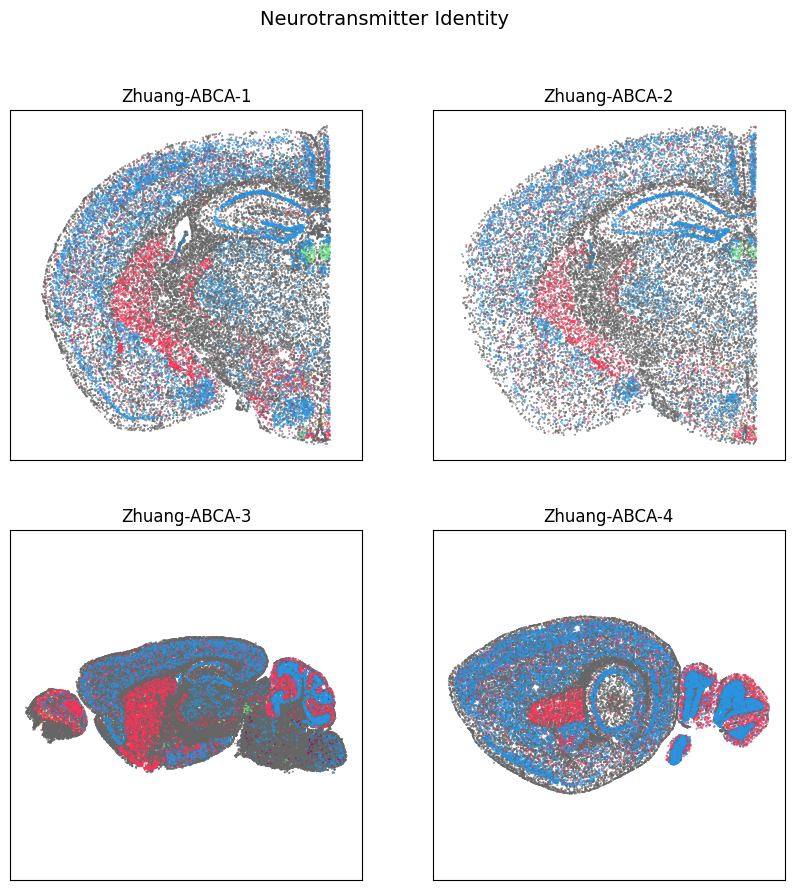

In [15]:
fig, ax = plot_sections(cell_extended, example_section, 'neurotransmitter_color')
res = fig.suptitle('Neurotransmitter Identity', fontsize=14)

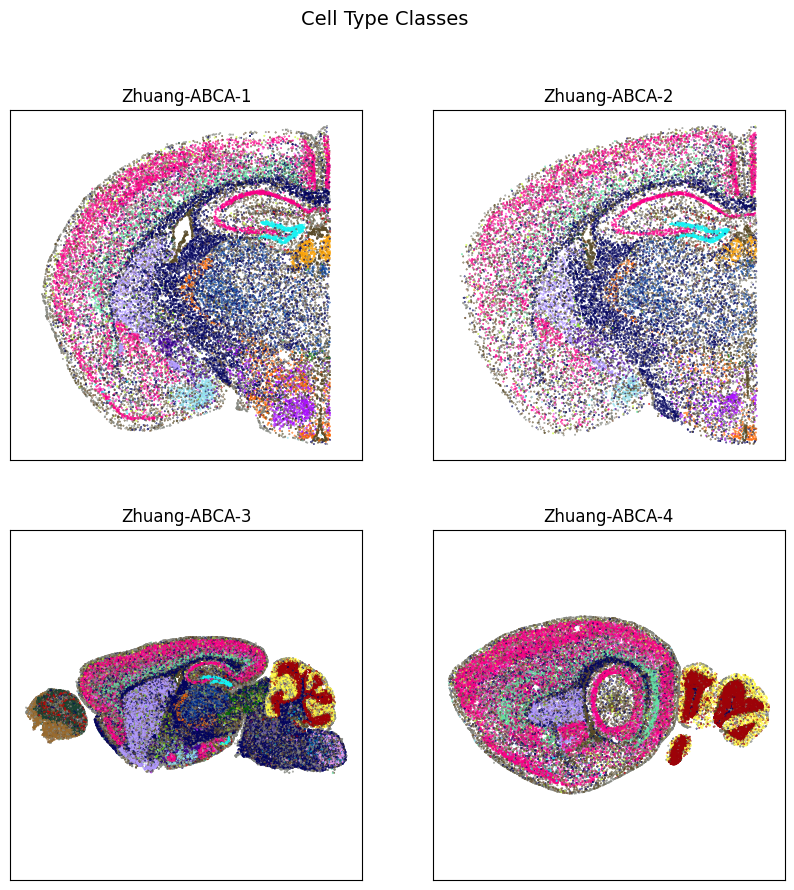

In [16]:
fig, ax = plot_sections(cell_extended, example_section, 'class_color')
res = fig.suptitle('Cell Type Classes', fontsize=14)

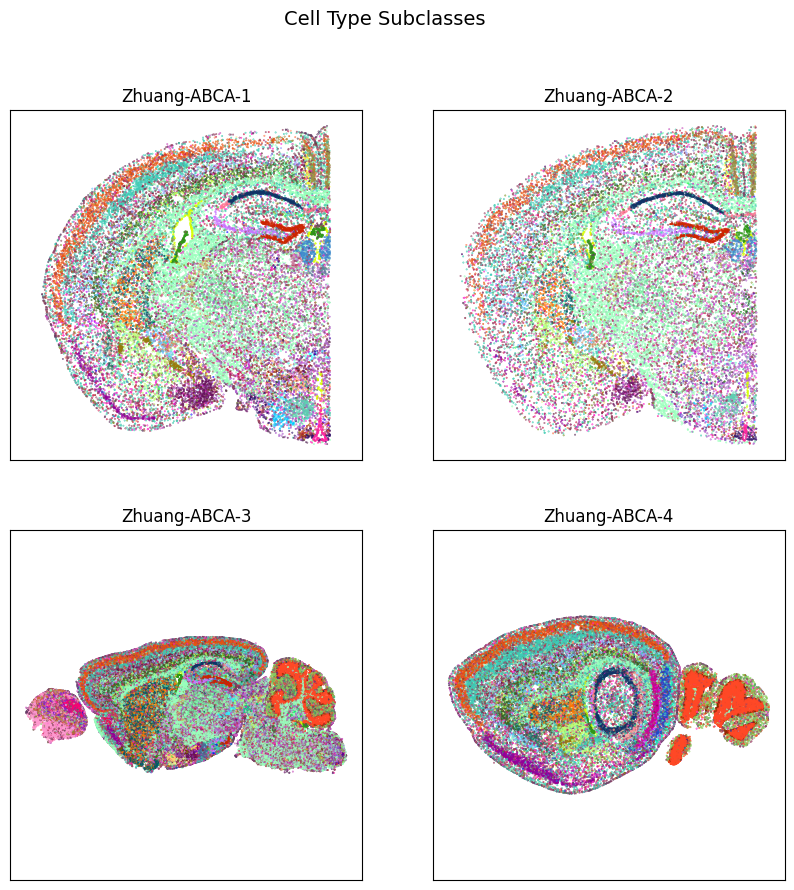

In [17]:
fig, ax = plot_sections(cell_extended, example_section, 'subclass_color')
res = fig.suptitle('Cell Type Subclasses', fontsize=14)

## Example use case

In this section, we visualize the expression of nine canonical neurotransmitter transporter genes. To support these use cases, we will create a smaller submatrix (all cells and 9 genes) that read it into dataframe. *Note this operation takes around 2-5 minutes*.

In [18]:
gnames = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc6a3', 'Slc6a4']
pred = [x in gnames for x in gene.gene_symbol]
gene_filtered = gene[pred]
gene_filtered

gene_symbol  \
gene_identifier                  
ENSMUSG00000019935     Slc17a8   
ENSMUSG00000021609      Slc6a3   
ENSMUSG00000037771     Slc32a1   
ENSMUSG00000039728      Slc6a5   
ENSMUSG00000070570     Slc17a7   
ENSMUSG00000020838      Slc6a4   
ENSMUSG00000030500     Slc17a6   

                                                                 name  \
gene_identifier                                                         
ENSMUSG00000019935  solute carrier family 17 (sodium-dependent ino...   
ENSMUSG00000021609  solute carrier family 6 (neurotransmitter tran...   
ENSMUSG00000037771  solute carrier family 32 (GABA vesicular trans...   
ENSMUSG00000039728  solute carrier family 6 (neurotransmitter tran...   
ENSMUSG00000070570  solute carrier family 17 (sodium-dependent ino...   
ENSMUSG00000020838  solute carrier family 6 (neurotransmitter tran...   
ENSMUSG00000030500  solute carrier family 17 (sodium-dependent ino...   

                   mapped_ncbi_identifier  
gene_identifier                            
ENSMUSG00000019935        NCBIGene:216227  
ENSMUSG00000021609         NCBIGene:13162  
ENSMUSG00000037771         NCBIGene:22348  
ENSMUSG00000039728        NCBIGene:104245  
ENSMUSG00000070570         NCBIGene:72961  
ENSMUSG00000020838         NCBIGene:15567  
ENSMUSG00000030500        NCBIGene:140919

In [19]:
abc_cache.list_data_files('Zhuang-ABCA-2')

['Zhuang-ABCA-2/log2', 'Zhuang-ABCA-2/raw']

In [20]:
cell_expression = {}

for d in datasets:    
    file = abc_cache.get_data_path(directory=d, file_name=f"{d}/log2")
    
    adata = anndata.read_h5ad(file, backed='r')
    
    start = time.process_time()
    gdata = adata[:, gene_filtered.index].to_df()
    gdata.columns = gene_filtered.gene_symbol
    cell_expression[d] = cell_extended[d].join(gdata)
    
    print(d,"-","time taken: ", time.process_time() - start)
    
    adata.file.close()
    del adata


Zhuang-ABCA-1-log2.h5ad: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2.13G/2.13G [02:23<00:00, 14.8MMB/s]


Zhuang-ABCA-1 - time taken:  19.471441


Zhuang-ABCA-2-log2.h5ad: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 871M/871M [02:38<00:00, 5.49MMB/s]


Zhuang-ABCA-2 - time taken:  10.082500999999993


Zhuang-ABCA-3-log2.h5ad: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1.16G/1.16G [04:33<00:00, 4.24MMB/s]


Zhuang-ABCA-3 - time taken:  9.916156


Zhuang-ABCA-4-log2.h5ad: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 107M/107M [00:04<00:00, 21.4MMB/s]


Zhuang-ABCA-4 - time taken:  1.1427290000000028


Visualize genes Slc17a7, Slc17a6, Slc32a1 for an example section from each brain

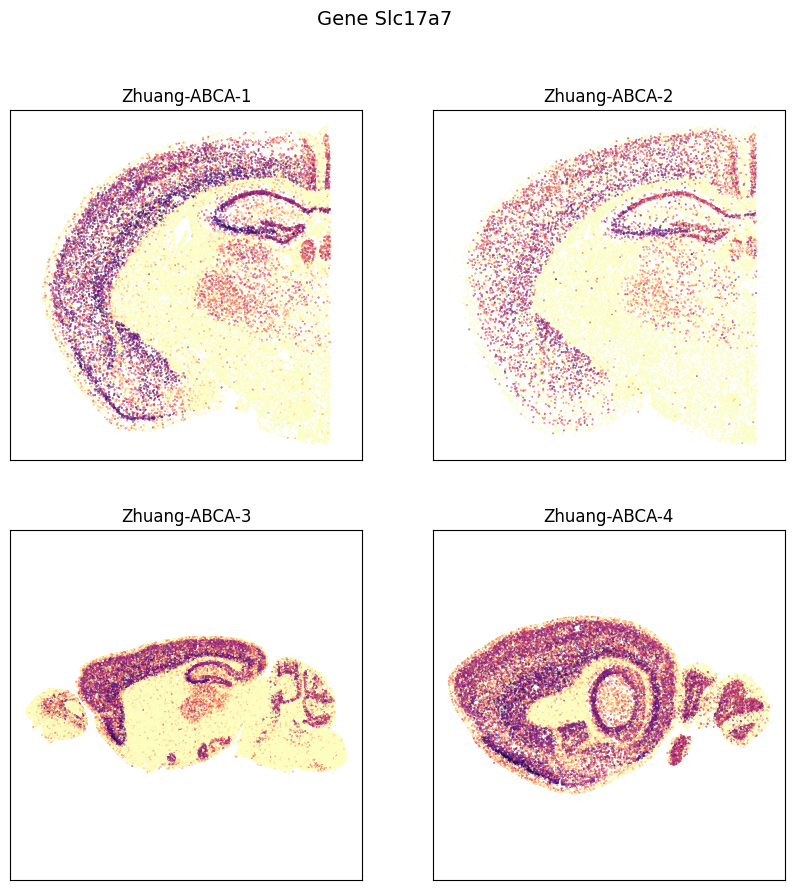

In [21]:
fig, ax = plot_sections(cell_expression, example_section, val='Slc17a7', cmap=plt.cm.magma_r)
res = fig.suptitle('Gene Slc17a7', fontsize=14)

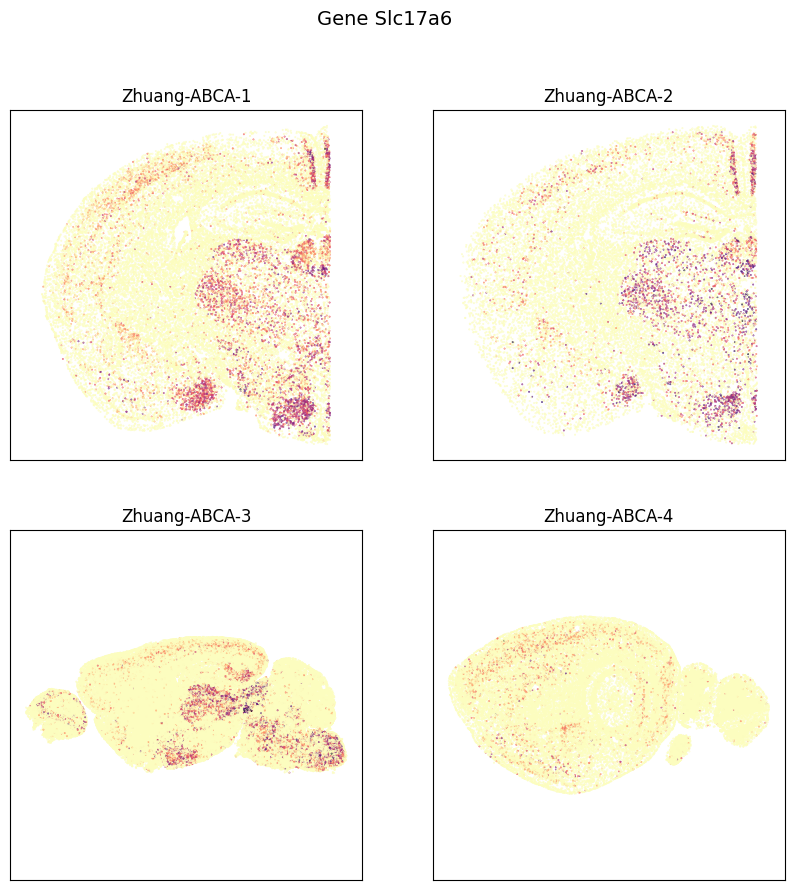

In [22]:
fig, ax = plot_sections(cell_expression, example_section, val='Slc17a6', cmap=plt.cm.magma_r)
res = fig.suptitle('Gene Slc17a6', fontsize=14)

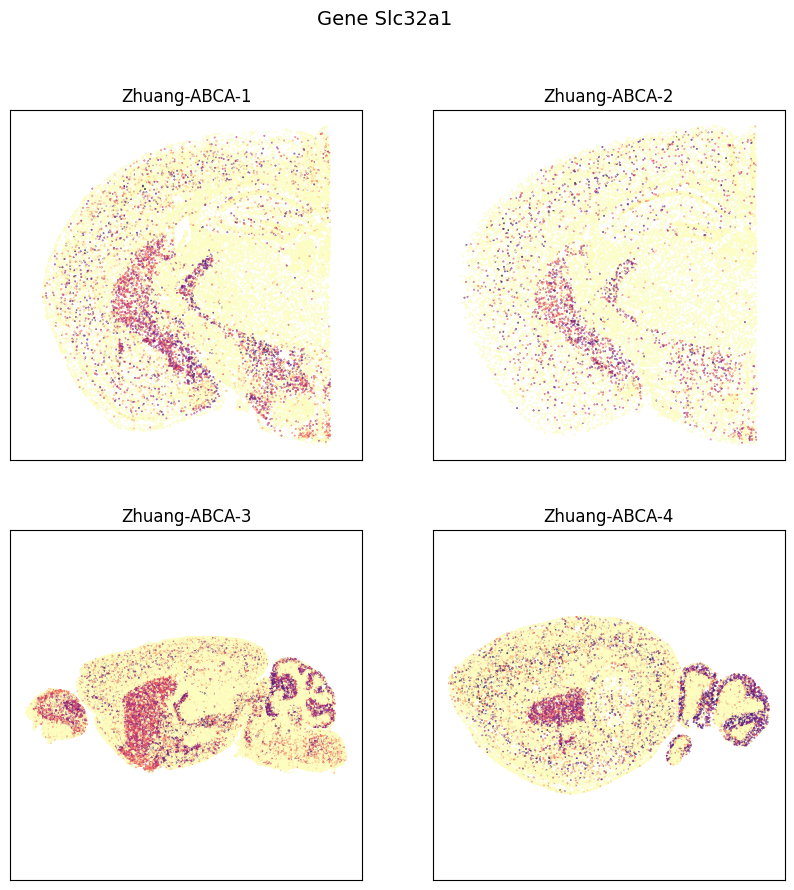

In [23]:
fig, ax = plot_sections(cell_expression, example_section, val='Slc32a1', cmap=plt.cm.magma_r)
res = fig.suptitle('Gene Slc32a1', fontsize=14)

### CCF registration and parcellation annotation

Each brain specimen has been registered to Allen CCFv3 atlas, resulting in an x, y, z coordinates and parcellation_index for each cell. 

In [24]:
ccf_coordinates = {}

for d in datasets :

    ccf_coordinates[d] = abc_cache.get_metadata_dataframe(directory=f"{d}-CCF", file_name='ccf_coordinates')
    ccf_coordinates[d].set_index('cell_label', inplace=True)
    ccf_coordinates[d].rename(columns={'x': 'x_ccf',
                                       'y': 'y_ccf',
                                       'z': 'z_ccf'},
                              inplace=True)
    
    cell_extended[d] = cell_extended[d].join(ccf_coordinates[d], how='inner')

ccf_coordinates.csv: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 221M/221M [00:08<00:00, 25.8MMB/s]
ccf_coordinates.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 89.1M/89.1M [00:03<00:00, 22.4MMB/s]
ccf_coordinates.csv: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 132M/132M [00:05<00:00, 23.2MMB/s]
ccf_coordinates.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13.8M/13.8M [00:00<00:00, 17.3MMB/s]


In [25]:
ccf_coordinates[datasets[0]]

x_ccf     y_ccf     z_ccf  \
cell_label                                                              
182941331246012878296807398333956011710  7.902190  3.048426  0.582962   
221260934538535633595532020856387724686  7.906513  3.145200  0.577602   
22228792606814781533240955623030943708   7.906110  3.182761  0.553731   
272043042552227961220474294517855477150  7.904627  3.131808  0.563525   
110116287883089187971185374239350249328  7.907236  3.230647  0.543048   
...                                           ...       ...       ...   
94310525370042131911495836073267655162   9.681244  4.453979  0.852027   
298798481479578578007190103666214714353  9.676999  4.291647  0.899531   
330756942354980576352210203729462562749  9.678760  4.363282  0.894082   
47305871059582831548494138048361484565   9.678641  4.360346  0.901195   
64578198410898899234789748167671783948   9.673530  4.138034  0.897311   

                                         parcellation_index  
cell_label                                                   
182941331246012878296807398333956011710                   0  
221260934538535633595532020856387724686                   0  
22228792606814781533240955623030943708                    0  
272043042552227961220474294517855477150                   0  
110116287883089187971185374239350249328                   0  
...                                                     ...  
94310525370042131911495836073267655162                    0  
298798481479578578007190103666214714353                1109  
330756942354980576352210203729462562749                1109  
47305871059582831548494138048361484565                 1109  
64578198410898899234789748167671783948                 1109  

[2616328 rows x 4 columns]

Read in the pivot table from the "parcellation annotation tutorial" to associate each cell with terms at each anatomical parcellation level and the corresponding color.

In [26]:
parcellation_annotation = abc_cache.get_metadata_dataframe(directory="Allen-CCF-2020",
                                                           file_name='parcellation_to_parcellation_term_membership_acronym')
parcellation_annotation.set_index('parcellation_index', inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]

parcellation_color = abc_cache.get_metadata_dataframe(directory="Allen-CCF-2020",
                                                      file_name='parcellation_to_parcellation_term_membership_color')
parcellation_color.set_index('parcellation_index', inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

In [27]:
for d in datasets :
    cell_extended[d] = cell_extended[d].join(parcellation_annotation, on='parcellation_index')
    cell_extended[d] = cell_extended[d].join(parcellation_color, on='parcellation_index')   

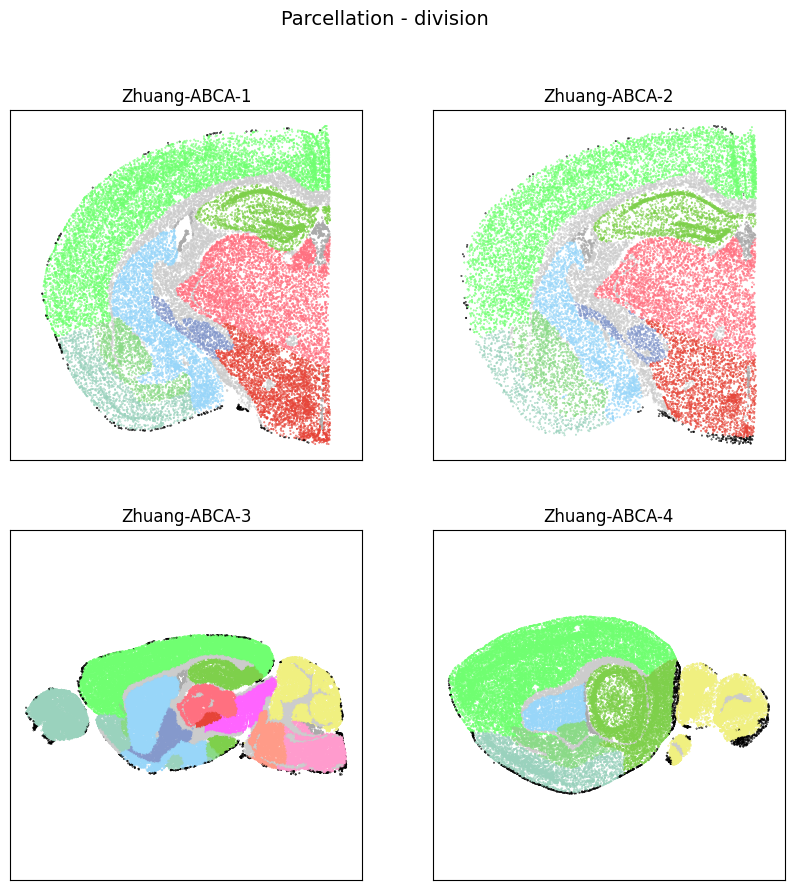

In [28]:
fig, ax = plot_sections(cell_extended, example_section, 'parcellation_division_color')
res = fig.suptitle('Parcellation - division', fontsize=14)

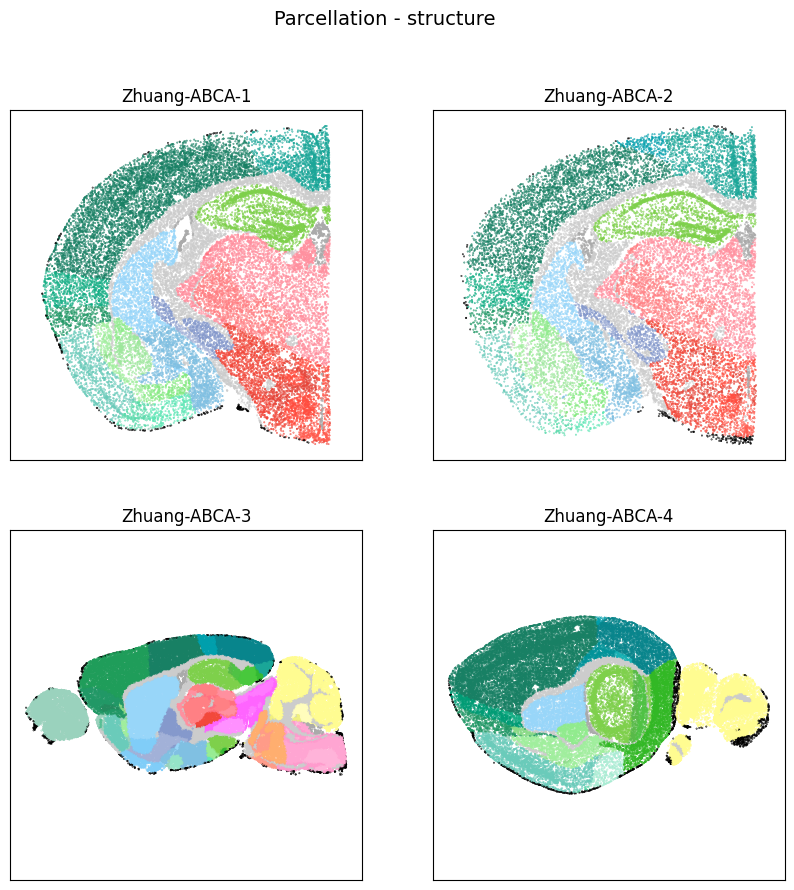

In [29]:
fig, ax = plot_sections(cell_extended, example_section, 'parcellation_structure_color')
res = fig.suptitle('Parcellation - structure', fontsize=14)

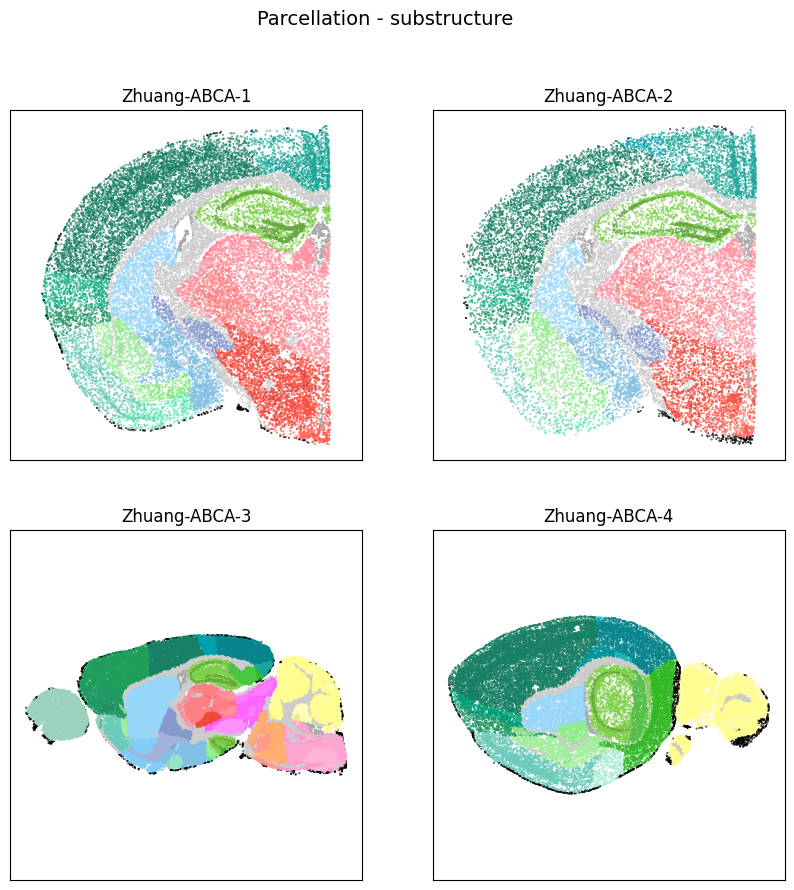

In [30]:
fig, ax = plot_sections(cell_extended, example_section, 'parcellation_substructure_color')
res = fig.suptitle('Parcellation - substructure', fontsize=14)